In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Lab 07 -- More NN

## Matthew Spinelli
## CSE 627

#### For Lab Assignment Submission

To start, I'm combining lab 06 and lab 07 as lab 07 starts off by recreating the logistic regression from lab 06 and uses tensorboard. Combining them allows me to visualize the weights and incorrect examples with some modificiation. Furthermore, lab 06 has many suggested additional exercise ideas to try and seems to be a good fit for a lab assignment submisison. 

# Summary: Things I did in this lab
- Repeat the logistic regression exercise but add tensorflow logging
- Save the model weights (via tensorboard checkpoints)
- Add a hidden layer to the net

The above is the original lab 07 description. I continued with:

**Explored some of the Lab 06 exercises**
- Added [L2 regularization](#Set-up-the-graph-for-training) and [added placeholder to feed lambda](#Set-up-a-net-to-estimate/predict-digits) into the graph to turn/toggle regularization.
- Changed [optimizer learning rate](#Set-up-the-graph-for-training)
- [Save and load weights and biases using numpy](#Saving-and-Loading-trainable-variables)

**Additional things I've done**
- [Visualize weights](#With-Regularization) from input to hidden and hidden to output layers   
 - Turns out that attempting to visualizing this the same way as lab 06 is problematic
 - Regularization does help the visualization to some degree
- Display [confusion matrix and plot using log scale](#Without-Regularization)
- [Create new log sub folders folders for each new restart/rerun](#Set-up-the-graph-for-training) of this notebook in tensorboard
- Played with different number of Epochs
 - More Epochs seems to slightly improve the score but improvement is minimal after about 20 epochs.
 - Fewer Epochs (around 4) show some details in the weight visualization. But otherwise, doing this wasn't that helpful.
- Improved test [accuracy compared](#Comparing-with-other-approaches) to lab 06 (and attempted to compared to lab 07). Also compared the [effect of regularization](#Without-Regularization).
- Explored tensorboard beyond loss and accuracy (looked at weights and biases) [TODO: add example pics]
- [Made the main training loop a function](#Train) so that I can rerun it as needed.

In [2]:
import tensorflow as tf
import numpy as np
import os
import re
import time
from sklearn.metrics import confusion_matrix

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


# Useful Methods from Lab 06:

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [4]:
def plot_images(images, cls_true, cls_pred=None, img_shape=(28,28)):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

Function for printing and plotting the confusion matrix using scikit-learn. **Modified to use log-scale**.

In [5]:
from matplotlib.colors import LogNorm

def print_confusion_matrix(num_classes=10):
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(pc, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', 
               norm=LogNorm(vmin=1, vmax=np.max(cm)), 
               cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Function for plotting examples of images from the test-set that have been mis-classified.

In [6]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct_, cls_pred = sess.run([correct, pc],
                                  feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct_ == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Function for plotting the `weights` of the model. 10 images are plotted, one for each digit that the model is trained to recognize.

In [7]:
def plot_weights(weights, img_shape):
    # Get the values for the weights from the TensorFlow variable.
    w = sess.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        else:
            ax.axis('off')
        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

# Set up a net to estimate/predict digits

In [8]:
# hyperparameters
num_inputs = 28*28
num_hidden1 = 32*32
num_outputs = 10

In [9]:
tf.reset_default_graph()

Input placeholders for the data `x` and the expected (1hot) labels `y`. **NOTE:** Added placeholder for lambda to tune regularization.

In [10]:
with tf.name_scope('input'):
    # THIS IS LIKE ONE LAYER OF A NEURAL NET:

    x = tf.placeholder(tf.float32, (None, 28*28), name='x')
    y = tf.placeholder(tf.float32, (None, 10), name='y')
    lambda_ = tf.placeholder(tf.float32, shape=(), name='lambda')
    ec = tf.argmax(y, 1, name='ec') #[e]xpected [c]lass label
  
    # When this node is run, it will save an image to a log file.
    #  - I am not assigning a variable to the result;,
    #    all of the summary nodes can be collected by inspecting the graph later on. 
    tf.summary.image("image", tf.reshape(x, [-1, 28,28,1]), max_outputs=3);

How do we create a hidden layer? It will look almost like the output with some modifications.

In [11]:
with tf.name_scope('hidden1'):   
    b1 = tf.Variable(tf.zeros(num_hidden1), name='b1')
    W1 = tf.Variable(tf.truncated_normal([num_inputs, num_hidden1]), name='W1')
    a1 = tf.add(tf.matmul(x, W1), b1, name='a1')  # x*W1 + b1
    z1 = tf.nn.softmax(a1, name='z1')
    
    # Create nodes that will save histograms to the log file
    #  -- histograms are good summaries of the (large) amount of data in the weights. 
    #  -- The let you spot common issues with gradient descent (stalling, diverging)
    tf.summary.histogram("weights", W1)
    tf.summary.histogram("biases", b1)
    tf.summary.histogram("activations", a1)

In tensorflow, you can create nodes in the graph whose purpose is to save information to log files. The log files can be inspected using a tool called [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). I hope to be able to demonstrate it later on in the notebook.

When we save data to the log file, the names become more important. We can group related nodes together using a 'name_scope' in order to make the log files easier to understand. 

In [12]:
with tf.name_scope('output'):   
    b2 = tf.Variable(tf.zeros(num_outputs), name='b2')
    W2 = tf.Variable(tf.truncated_normal([num_hidden1, num_outputs]), name='W2')
    a2 = tf.add(tf.matmul(z1, W2), b2, name='a2') # z1 * W2 + b2
    z2 = tf.nn.softmax(a2, name='z2')
    pc = tf.argmax(z2, 1, name='pc')  # [p]redicted [c]lass label
    
    # Create nodes that will save histograms to the log file
    #  -- histograms are good summaries of the (large) amount of data in the weights. 
    #  -- The let you spot common issues with gradient descent (stalling, diverging)
    tf.summary.histogram("weights", W2)
    tf.summary.histogram("biases", b2)
    tf.summary.histogram("activations", pc)

The net is now complete for doing _inference_ or _estimation_. That is, you could use it (if the weights were set). Right now the weights are randomly set, the results will be random.

In [13]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
feed_dict_test = {x: data.test.images,
                  y: data.test.labels,
                  lambda_: 0, # doesn't matter for this, but it complained if I didn't add lambda
                  ec: data.test.cls}

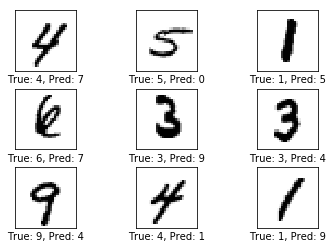

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_batch, y_batch = data.test.next_batch(9)
predictions = sess.run(pc, {x:x_batch, y:y_batch})
plot_images(x_batch, y_batch.argmax(1), predictions)

**NOTE:** Let's reload the data because doing next_batch on the test data seems to cause problems when we try to show the failures after training (not sure why, and if I had more time I could fix the code instead of just merely reloading the data). I believe this is an issue in the original lab too.

In [15]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
data.test.cls = np.array([label.argmax() for label in data.test.labels])
feed_dict_test = {x: data.test.images,
                  y: data.test.labels,
                  lambda_: 0, # doesn't matter for this, but it complained if I didn't add lambda
                  ec: data.test.cls}

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


# Set up the net for evaluation

In [16]:
with tf.name_scope('accuracy'):
    correct = tf.equal(ec, pc, name='correct')  # for each sample, did we get it right? 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='acc')

    # Create a node to save the accuracy to a log file, 
    # so that we can go back and see how it improves after training. 
    tf.summary.scalar('accuracy', accuracy);  # ACTUALLY MAKES A PLOT

In [17]:
# Normally, we would need to break the test data up into mini-batches.
# however, this set is small enough that we will send the entire 
# test set in as one large batch. 
print "Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
print "Random chance is around 0.10 (10%)"

Accuracy: 0.0949
Random chance is around 0.10 (10%)


# Save the log/summary data

Before we start training, let's look at the log data. 

*NOTE:* All log files will accumulate in the folder unless you delete them, or switch to a different log folder. If you are running this many times and adjusting settings, it is a good idea to think about how to choose differently named log folders for output. 

In [18]:
!mkdir -p ./log/run0

In [19]:
# Collect all of the 'summary' nodes from the graph and generate a single log entry from them. 
summary = tf.summary.merge_all()

In [20]:
# A utility to save summarys to the log directory. 
#  -- This will create a file, each time we add a summary to the writer it gets appended to a log file.
summary_writer = tf.summary.FileWriter('./log/run0', graph=sess.graph)

In [21]:
acc, log =  sess.run([accuracy, summary],        # ACC, AND LOG BACAUSE HE DIDN'T WANT TO OVERWRITE THE VARIABLES
                     {x:data.test.images, y:data.test.labels, lambda_:0.001})
summary_writer.add_summary(log, 0)

In order to train the net, we need to define an objective function to minimize. In this case we will use the cross-entropy loss because our output it a softmax classification. 

In [22]:
from pipes import quote
print "Acuracy:", acc
print 
print "Make sure the correct conda environment is active, then run:"
print "    tensorboard --logdir={} ".format(quote(os.path.abspath('./log')))
print "and open"
print "    http://localhost:6006/"
print "using your web browser"

Acuracy: 0.0949

Make sure the correct conda environment is active, then run:
    tensorboard --logdir=/Users/mattspinnelli/repositories/school/cse627a/labs/lab-07/my_solutions/log 
and open
    http://localhost:6006/
using your web browser


# Set up the graph for training

**NOTE:** Modified to include L2 regularization

In [23]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a2)   
    unregularized_loss = tf.reduce_mean(cross_entropy, name='unregularized_loss')

    # using L2 Regularization
    l2_loss = lambda_ * (tf.nn.l2_loss(W1, name ='W1_reg') + 
                         tf.nn.l2_loss(W2, name ='W2_reg')) 
    loss = tf.add(unregularized_loss, l2_loss, name='loss')
        
    # And define a node to log it
    tf.summary.scalar('loss', loss);

**NOTE:**  So that we can do more Epochs faster, changed learning rate from 0.001 to 0.01. It doesn't seem to adversely affect the result.

In [24]:
with tf.name_scope('solver'):
    # GENERALLY FASTER THAN STOCASTIC GRADIENT DESCENT BUT NOT AS EASY TO UNDERSTAND
    solver = tf.train.AdamOptimizer(learning_rate=0.01) 
    optimize = solver.minimize(loss)

**NOTE:** Create a new sub folder each time we run this notebook and clear out the checkpoint weights (as I am not going to need to reuse them between restarts of this notebook.)

In [25]:
!rm models/*.*

In [26]:
summary_writer = tf.summary.FileWriter('./log/run{}/'.format(time.strftime("%Y%m%d_%H%M")), graph=sess.graph)

In [27]:
# The solver has some parameters that need to be initializes
sess.run(tf.global_variables_initializer())

In [28]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [29]:
!mkdir -p ./models

In [30]:
summary = tf.summary.merge_all()

# Train

**Note:** updated to be a function and to allow alternative way of loading trainable using np.load if a file path is passed in (npy_file).

In [31]:
def train(batch_size=100, 
          training_epochs=1, 
          display_epoch=1, 
          npy_file = None,
          lambda_value = 0):
    try:
        if npy_file:
            var_dict = np.load(file_path)
            sess.run(b1.assign(var_dict['b1']))
            sess.run(W1.assign(var_dict['W1']))
            sess.run(b2.assign(var_dict['b2']))
            sess.run(W2.assign(var_dict['W2']))
            print "Restored weights via numpy."
        else:
            saver.restore(sess, './models/logreg.cpt')

    except:
        print "No model to restore or failure to restore."

    for epoch in range(training_epochs):
        avg_loss = 0.
        total_batch = int(data.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_xs, batch_ys = data.train.next_batch(batch_size)

            _, loss_, summary_ = sess.run([optimize, loss, summary],
                                          {x: batch_xs, y: batch_ys, lambda_: lambda_value})

            global_iteration =  epoch * total_batch + i
            summary_writer.add_summary(summary_, global_iteration)

            avg_loss += loss_ / total_batch


        # Display logs per epoch step
        if (epoch+1) % display_epoch == 0:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_loss)

        saver.save(sess, './models/logreg.cpt')

In [32]:
train()

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
No model to restore or failure to restore.
Epoch: 0001 cost= 0.669452067


# Without Regularization

First let's run it without regularization to get a point of reference to later compare the results with regularization. We'll start by accessing accuracy and visualizing weights after 1, 2, and 20 epochs. Then do the same using regularization.

So without regularization the weights look mostly like noise when visualized as they were in lab 6 (there is some pattern here though).

Test Accuracy: 0.9201


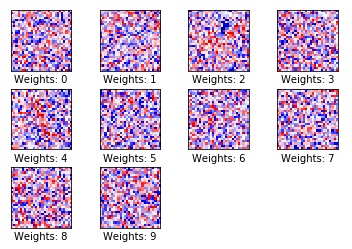

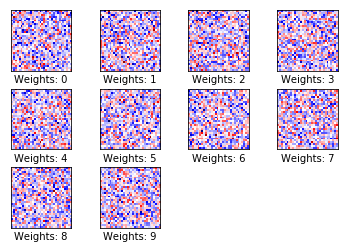

In [33]:
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

Still pretty noisy, but accuracy does improve.

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
Epoch: 0001 cost= 0.312396762
Test Accuracy: 0.9329


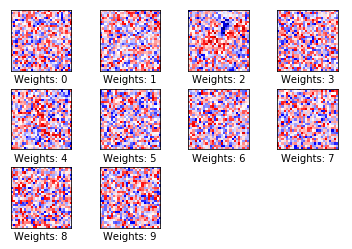

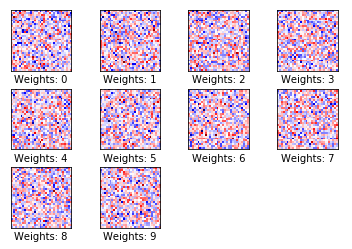

In [34]:
train()
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

Final results after 20 total epochs. Some weights in W1 seem to have a noticible pattern (sometimes, other runs of this notebooks not so much). I guess due to the stocastic nature of the optimizer this can change between runs. Still usually there is some pattern in the visualization. I'll talk more about this in the next setion.

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
Epoch: 0001 cost= 0.260557329
Epoch: 0002 cost= 0.222882410
Epoch: 0003 cost= 0.193324684
Epoch: 0004 cost= 0.181643752
Epoch: 0005 cost= 0.170315517
Epoch: 0006 cost= 0.159737696
Epoch: 0007 cost= 0.148145470
Epoch: 0008 cost= 0.148030727
Epoch: 0009 cost= 0.138760676
Epoch: 0010 cost= 0.128634997
Epoch: 0011 cost= 0.123232833
Epoch: 0012 cost= 0.118612734
Epoch: 0013 cost= 0.116424936
Epoch: 0014 cost= 0.111659632
Epoch: 0015 cost= 0.111637164
Epoch: 0016 cost= 0.108113880
Epoch: 0017 cost= 0.106236372
Epoch: 0018 cost= 0.099585988
Test Accuracy: 0.9612


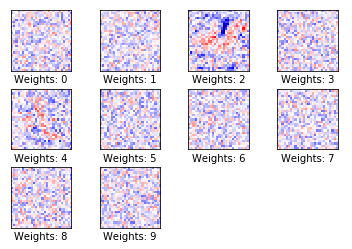

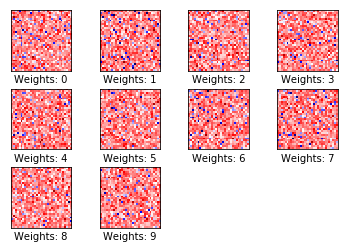

In [35]:
train(training_epochs=18)
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

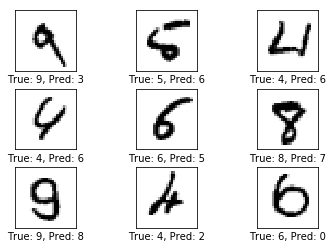

In [36]:
plot_example_errors()

[[ 965    0    0    2    1    5    4    1    1    1]
 [   0 1121    3    0    1    2    2    1    5    0]
 [   4    3  995    3    1    0    1    9   14    2]
 [   0    0   15  955    1    8    0    8   11   12]
 [   2    0    5    2  948    0    7    3    5   10]
 [   4    2    2   19    1  842    8    3    6    5]
 [   8    3    2    2    4    8  924    0    7    0]
 [   0    3   12    6    4    0    0  989    2   12]
 [   4    0   12   13    6    6    1    6  915   11]
 [   2    2    1    6   15    5    1   11    8  958]]


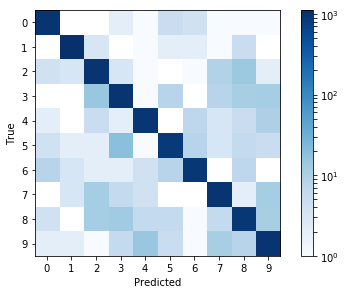

In [37]:
print_confusion_matrix()

# With Regularization

Now let's try with regularization. I noticed if I used too much the weights just end up visualizing as all blue or red (or a pastel varient of these colors). So using just a tiny amount seems to bring out more of a pattern into the weight visualizaiton. Whether this is useful thing to do I'm not really sure, but it seems to have an effect and that sounds like an important observation. Also in this section I'll play around with saving the weights using numpy. Also, we'll create a new log sub folder to make it easier to compare in tensorflow.

In [38]:
!rm models/*.*
sess.close()
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('./log/run{}/'.format(time.strftime("%Y%m%d_%H%M")), graph=sess.graph)
sess.run(tf.global_variables_initializer())
train(lambda_value=0.00000001)

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
No model to restore or failure to restore.
Epoch: 0001 cost= 0.654955998


So after just 1 Epoch accuracy is pretty good ~ 91-92%

In [39]:
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})

Test Accuracy: 0.9203


I was curious what would happen if I took the weight visualization code and adapted to this network with a hiden layer. So initially we see some structure here, at least for the first set of weights (W1). But unlike lab 6, seeing the visualizations in a pattern and sequence that follows 0, 1, 2, ... 9 order doesn't really happen here. You might see some number-like patterns in the visualization that don't match the weight labels they belong to. Unless there is a bug in the code, I suspect this is because of the interaction between the weights connecting input with hidden and hidden with output. Also what the network is learning may not neccessarily make much sense to us when we visualize this way. Any pattern in W2 weights is hard to see, which makes sense considering the size of the hidden layer is 32x32 and no longer matches the input layer (at least this is one reason I can think of).

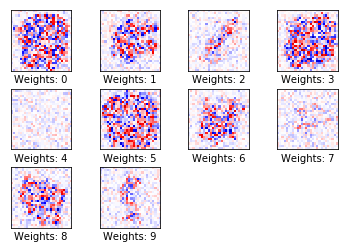

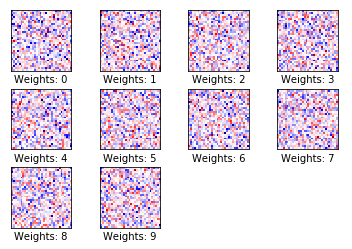

In [40]:
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

## Saving and Loading trainable variables

First let's save the weights to a file.

In [41]:
def save_npz(sess, npy_path='lab07_weights_and_biases.npz'):
    timestr = "_" + time.strftime("%Y%m%d_%H%M")
    file_path = npy_path[:-4] + timestr + npy_path[-4:]
    var_dict = {}
    for var in tf.trainable_variables():
        name = re.search(r"/(.+):", var.name).group(1)
        var_out = sess.run(var)
        if name not in var_dict:
            var_dict[name] = {}
        var_dict[name]= var_out

    np.savez(file_path, **var_dict)    
    return file_path

In [42]:
file_path = save_npz(sess)
print "File saved as:", file_path

File saved as: lab07_weights_and_biases_20171214_0040.npz


Now we'll close the session, reopen it, and then run train using the np.savez'd weights to continue training. The cost should be going down in line with where it left off above (and it does).

In [43]:
sess.close()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train(lambda_value=0.00000001, npy_file = file_path)

Restored weights via numpy.
Epoch: 0001 cost= 0.301464046


After 2 epochs, the accuracy goes from around 91-92% to around 93-94%. Visualizing the weights at this point often seems to have less detail than when we did just 1 epoch (but this changes each time I rerun this notbook do to the stocastic nature of the learning).

Test Accuracy: 0.9321


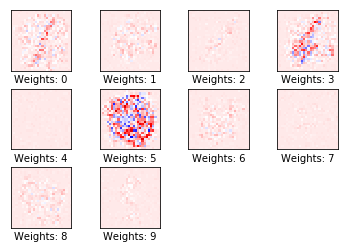

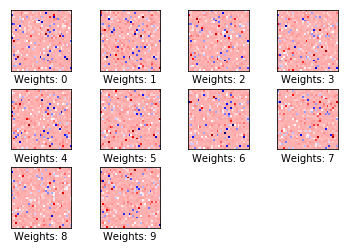

In [44]:
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

Let's now continue on to do a total of 20 epochs and verify that restoring from the checkpoint worked.

In [45]:
train(training_epochs=18, lambda_value=0.00000001)

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
Epoch: 0001 cost= 0.243524833
Epoch: 0002 cost= 0.220152216
Epoch: 0003 cost= 0.195794955
Epoch: 0004 cost= 0.184737887
Epoch: 0005 cost= 0.168647397
Epoch: 0006 cost= 0.160205574
Epoch: 0007 cost= 0.151001324
Epoch: 0008 cost= 0.141006185
Epoch: 0009 cost= 0.139086902
Epoch: 0010 cost= 0.131831526
Epoch: 0011 cost= 0.127609954
Epoch: 0012 cost= 0.122659489
Epoch: 0013 cost= 0.123100900
Epoch: 0014 cost= 0.115460419
Epoch: 0015 cost= 0.112518220
Epoch: 0016 cost= 0.111186540
Epoch: 0017 cost= 0.106925279
Epoch: 0018 cost= 0.107462379


## Comparing with other approaches

Accuracy is now 95-96%, which is better than what we got in Lab 6 ( ~91-92 %) but probably not much better than how we did in class as I recall (which is like the non-regularized version above). Regularizion doesn't seem to help improve test accuracy in this case but it is interesting it affects the visualization of the weights (some runs through this notebook I see patterns in W1).

Test Accuracy: 0.9578


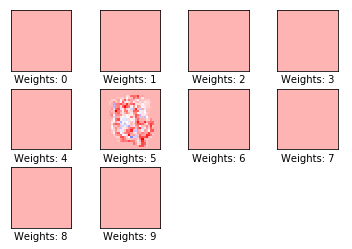

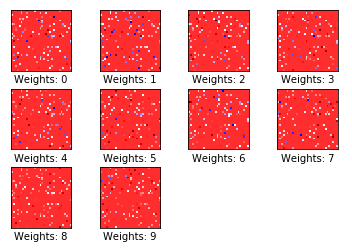

In [46]:
print "Test Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
plot_weights(W1, (28, 28))
plot_weights(W2, (32, 32))

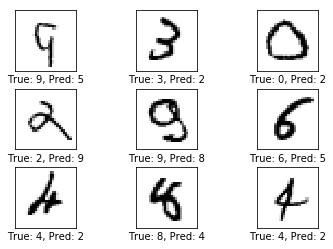

In [47]:
plot_example_errors()

[[ 963    1    2    0    0    3    8    1    1    1]
 [   0 1122    4    0    1    0    3    1    4    0]
 [   5    0  990    5    2    0    3    4   22    1]
 [   1    1   10  956    0    9    0    4   16   13]
 [   1    1   16    0  935    0    5    3    2   19]
 [   3    0    2   15    0  836   10    2   17    7]
 [   4    3    7    1    4   10  923    0    6    0]
 [   1    9   14    5    1    1    0  974    5   18]
 [   2    2   10   11    6    3    5    4  923    8]
 [   5    5    3    3   14    6    1    8    8  956]]


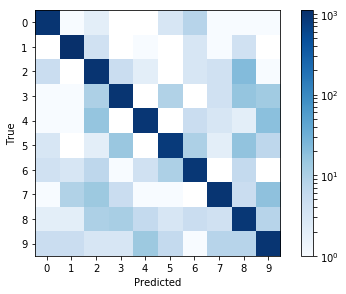

In [48]:
print_confusion_matrix()

Comparing the confusion matrices it also seems like the non-regularized version worked a bit better, but this could be do to random chance too as they results are really close and another run might give different results.